In [1]:
using LogDensityProblems: LogDensityProblems;
using Distributions
using DelimitedFiles
using Random: Random


data = readdlm("data.txt")
t, y, yerr = data[:, 1], data[:, 2], data[:, 3]


([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0], [-7.847359573362729, -1.3315947853190484, -0.5803510819209906, 1.1102764392598465, 9.988712842023517, 19.064552472027945, 22.360242601879634, 33.29037569667121, 44.30268624603188, 61.37029298584822  …  329.46633376403497, 367.3951090879816, 401.4586394961345, 429.0802630665355, 468.61496107560146, 507.32002150234865, 545.8993822489858, 589.8509862829196, 640.5342047989809, 675.5419963803967], [2.3730589643393882, 1.3446357078635467, 0.21190807702627767, 2.4126456988021374, 1.4574964737150893, 4.5564066433504316, 2.007971577637596, 1.5027663187179967, 2.6671045028916103, 1.8335143799268723  …  2.4187475006856918, 3.7358953477686847, 3.7144608329447912, 4.750626684174312, 0.10958338163060743, 4.894885896061309, 0.732250812640492, 2.748137898114247, 4.061190017100702, 0.033932572914373016])

In [2]:
# Let's define some type that represents the model.
struct RegressionProblem{Ty <: AbstractVector}
	"mean of the isotropic Gaussian"
	y::Ty
	x::Ty
	# α::A
	# β::A
	# γ::A
end
LogDensityProblems.dimension(model::RegressionProblem) = 3

function LogDensityProblems.logdensity(model::RegressionProblem, θ::AbstractVector{<:Real})
	α, β, γ = θ
	lp = logpdf(Normal(2, 1), α)
	lp += logpdf(Normal(0, 1), β)
	lp += logpdf(Normal(-2, 1), γ)
	ll = logpdf(MvNormal(fun(model.x, α, β, γ), 1), model.y)
	return ll + lp
end


fun(x,α,β,γ) = @. α * x^2 + β * x + γ
x = 0.0:0.5:15.0

LogDensityProblems.capabilities(model::RegressionProblem) = LogDensityProblems.LogDensityOrder{0}()

In [3]:
MYmodel = RegressionProblem(y,t)

RegressionProblem{Vector{Float64}}([-7.847359573362729, -1.3315947853190484, -0.5803510819209906, 1.1102764392598465, 9.988712842023517, 19.064552472027945, 22.360242601879634, 33.29037569667121, 44.30268624603188, 61.37029298584822  …  329.46633376403497, 367.3951090879816, 401.4586394961345, 429.0802630665355, 468.61496107560146, 507.32002150234865, 545.8993822489858, 589.8509862829196, 640.5342047989809, 675.5419963803967], [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0])

In [4]:
function tune_lengthscale(t, μ, N_e, N_c, M_adapt)
	N_e = max(1, N_e)

	if t <= M_adapt
		return 2μ * N_e / (N_e + N_c)
	else
		return μ
	end
end

function get_complementary(i, N)
	indices = collect(1:N)
	deleteat!(indices, i)
	return indices
end

function get_direction_vector(S, l, m, μ)
	return μ * (S[l, :] - S[m, :])
end

""" 
	DifferentialMove(rng, k, μ, S, N)

	Perform a differential move for walker k.

	# Arguments
	- `rng::AbstractRNG`: Random number generator.
	- `k::Int`: Index of the walker.
	- `μ::Float64`: Lengthscale.
	- `S::Array{Float64, 2}`: Array of walker positions.
	- `N::Int`: Number of walkers.

	# Returns
	- `ηₖ::Array{Float64, 1}`: Differential move.
"""
function DifferentialMove(rng, k, μ, S, N)
	# work on walker k
	indices = get_complementary(k, N)
	# draw two random indices from the complementary set, without replacement
	l, m = sample(rng, indices, 2, replace = false)
	return get_direction_vector(S, l, m, μ)
end

DifferentialMove

In [5]:
using AbstractMCMC

struct EnsembleSliceSampler{T<:Float64,A<:Int64} <: AbstractMCMC.AbstractSampler
    "initial length scale"
    μ_init::T
    "number of adapation steps"
    M_adapt::A
    "number of walkers"
    N_walkers::A
    "max number of attempts"
    max_steps::A
end

struct ESState{A<:AbstractMatrix{<:Real},T<:Float64,B<:Int64}
    "current position"
    x::A
    "length scale"
    μ::T
    "iteration"
    t::B
end

struct ESSample{A<:AbstractMatrix{<:Real}}
    "current position"
    x::A # a matrix of dimension n_walkers * n_params
end

In [6]:
function AbstractMCMC.step(
	rng::Random.AbstractRNG,
	model_wrapper::AbstractMCMC.LogDensityModel,
	sampler::EnsembleSliceSampler,
	state::ESState)

	model = model_wrapper.logdensity
	# extract the sampler parameters
	μ = sampler.μ_init
	M_adapt = sampler.M_adapt
	N_walkers = sampler.N_walkers
	max_steps = sampler.max_steps

	f(x) = LogDensityProblems.logdensity(model, x)

	# extract current state
	x, μ, t = state.x, state.μ, state.t
	N_dim = size(x, 2)

	x_new = Matrix{Float64}(undef, N_walkers, N_dim)

	R, L, N_e, N_c = 0, 0, 0, 0
	X′ = 0

	# loop over the walkers
	for k in 1:N_walkers

		Xₖ = x[k, :] # get the current position of walker k
		ηₖ = DifferentialMove(rng, k, μ, x, N_walkers) # get the differential move

		δ = rand(rng, Exponential(1))
		Y = f(Xₖ) - δ

		L = -rand(rng)
		R = L + 1
		l = 0
		while Y < f(L .* ηₖ + Xₖ)
			L = L - 1
			N_e = N_e + 1
			l += 1
			if l == max_steps
				println("L: ", L, " Y: ", Y, " f(L): ", f(L .* ηₖ + Xₖ))
				error("Max steps reached", " iteration: ", t, " walker: ", k)
			end
		end
		l = 0
		while Y < f(R .* ηₖ + Xₖ)
			R = R + 1
			N_e = N_e + 1
			l += 1
			if l == max_steps
				println("L: ", R, " Y: ", Y, " f(R): ", f(R .* ηₖ + Xₖ))
				error("Max steps reached")
			end
		end

		l = 0
		while true
			l += 1
			X′ = rand(rng, Uniform(L, R))
			Y′ = f(X′ .* ηₖ + Xₖ)
			if Y < Y′
				break
			end
			if X′ < 0
				L = X′
				N_c = N_c + 1
			else
				R = X′
				N_c = N_c + 1
			end
			if l == max_steps
				println("L: ", R, " Y: ", Y, " f(R): ", f(R .* ηₖ + Xₖ))

				error("Max steps reached")
			end
		end

		Xₖ = X′ .* ηₖ + Xₖ
		x_new[k, :] = Xₖ
	end
	# println("R: ", R, " L: ", L, " N_e: ", N_e, " N_c: ", N_c, " μ: ", μ)
	μ = tune_lengthscale(t, μ, N_e, N_c, M_adapt)
	t += 1
	state_new = ESState(x_new, μ, t)
	return ESSample(state_new.x), state_new
end


In [15]:
rng = Random.default_rng(89)
ndims = 3
nwalkers = 2 * ndims
sampler = EnsembleSliceSampler(1.0, 100, 6, 10_000)
state = ESState(randn(rng,nwalkers,ndims), 1.0, 1)

ESState{Matrix{Float64}, Float64, Int64}([0.673852079462492 1.14199500806066 -1.7387812602231925; 0.25248360463904007 0.28402216943591785 0.07846764884484775; … ; 1.653954566521514 -2.643544363147885 0.5707286719915043; -0.11375400385570497 -0.050350176102250836 -0.3248607950393937], 1.0, 1)

In [36]:
rng = Random.default_rng(2)

x_next, state_next = AbstractMCMC.step(
    rng,
    AbstractMCMC.LogDensityModel(MYmodel),
    sampler,
    state
)

(ESSample{Matrix{Float64}}([3.336747856009186 -4.4205922785895275 -0.8034498583259676; 2.896134889898986 -3.5941629909431407 1.4178435421665991; … ; 2.932717619267433 -1.856444288582819 -0.6460086061206372; 1.5311634139711567 0.17068811762553684 -3.064647095231276]), ESState{Matrix{Float64}, Float64, Int64}([3.336747856009186 -4.4205922785895275 -0.8034498583259676; 2.896134889898986 -3.5941629909431407 1.4178435421665991; … ; 2.932717619267433 -1.856444288582819 -0.6460086061206372; 1.5311634139711567 0.17068811762553684 -3.064647095231276], 1.6774193548387097, 2))

In [18]:
function AbstractMCMC.step(
    rng::Random.AbstractRNG,
    model_wrapper::AbstractMCMC.LogDensityModel,
    ::EnsembleSliceSampler;
    kwargs...)
    model = model_wrapper.logdensity
    nwalkers = sampler.N_walkers
    ndims = LogDensityProblems.dimension(model)
    x = randn(rng,nwalkers,ndims)
    return ESSample(x), ESState(x,1.0,1)
end

In [33]:
using LinearAlgebra

@model function InferenceModel(y, t)
	α ~ Normal(2, 1)
	β ~ Normal(0, 1)
	γ ~ Normal(-2, 1)
	return y ~ MvNormal(fun(t, α, β, γ), I)
end

mymod = InferenceModel(y, t)
Turing.Inference.getparams(::Turing.Model, sample::ESSample) = sample.x

In [35]:
mymod

DynamicPPL.Model{typeof(InferenceModel), (:y, :t), (), (), Tuple{Vector{Float64}, Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(InferenceModel, (y = [-7.847359573362729, -1.3315947853190484, -0.5803510819209906, 1.1102764392598465, 9.988712842023517, 19.064552472027945, 22.360242601879634, 33.29037569667121, 44.30268624603188, 61.37029298584822  …  329.46633376403497, 367.3951090879816, 401.4586394961345, 429.0802630665355, 468.61496107560146, 507.32002150234865, 545.8993822489858, 589.8509862829196, 640.5342047989809, 675.5419963803967], t = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]), NamedTuple(), DynamicPPL.DefaultContext())

In [34]:
chain = sample(mymod, externalsampler(sampler), 10)

Sampling   0%|                                          |  ETA: N/A
Sampling 100%|██████████████████████████████████████████| Time: 0:00:00


MethodError: MethodError: no method matching unflatten(::DynamicPPL.TypedVarInfo{@NamedTuple{α::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:α, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:α, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, β::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:β, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:β, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, γ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:γ, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:γ, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, ::Matrix{Float64})

Closest candidates are:
  unflatten(::DynamicPPL.TypedVarInfo, !Matched::NamedTuple)
   @ Turing ~/.julia/packages/Turing/r3Hmj/src/mcmc/Inference.jl:165
  unflatten(::DynamicPPL.VarInfo, !Matched::AbstractMCMC.AbstractSampler, !Matched::AbstractVector)
   @ DynamicPPL ~/.julia/packages/DynamicPPL/DvdZw/src/varinfo.jl:137
  unflatten(::DynamicPPL.VarInfo, !Matched::AbstractVector)
   @ DynamicPPL ~/.julia/packages/DynamicPPL/DvdZw/src/varinfo.jl:134
  ...


In [32]:
# samples = sample(MYmodel, sampler, 10_000; initial_state=state, progress=true)


Sampling   0%|                                          |  ETA: N/A
Sampling 100%|██████████████████████████████████████████| Time: 0:00:00


MethodError: MethodError: no method matching unflatten(::DynamicPPL.TypedVarInfo{@NamedTuple{α::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:α, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:α, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, β::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:β, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:β, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, γ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:γ, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:γ, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, ::Matrix{Float64})

Closest candidates are:
  unflatten(::DynamicPPL.TypedVarInfo, !Matched::NamedTuple)
   @ Turing ~/.julia/packages/Turing/r3Hmj/src/mcmc/Inference.jl:165
  unflatten(::DynamicPPL.VarInfo, !Matched::AbstractMCMC.AbstractSampler, !Matched::AbstractVector)
   @ DynamicPPL ~/.julia/packages/DynamicPPL/DvdZw/src/varinfo.jl:137
  unflatten(::DynamicPPL.VarInfo, !Matched::AbstractVector)
   @ DynamicPPL ~/.julia/packages/DynamicPPL/DvdZw/src/varinfo.jl:134
  ...


In [22]:
samples = sample(MYmodel, sampler, 10_000; initial_state=state, progress=true)


Sampling   0%|                                          |  ETA: N/A
Sampling   0%|▎                                         |  ETA: 0:00:29
Sampling   1%|▍                                         |  ETA: 0:00:16
Sampling   2%|▋                                         |  ETA: 0:00:10
Sampling   2%|▉                                         |  ETA: 0:00:08
Sampling   2%|█                                         |  ETA: 0:00:06
Sampling   3%|█▎                                        |  ETA: 0:00:05
Sampling   4%|█▌                                        |  ETA: 0:00:05
Sampling   4%|█▋                                        |  ETA: 0:00:04
Sampling   4%|█▉                                        |  ETA: 0:00:04
Sampling   5%|██▏                                       |  ETA: 0:00:03
Sampling   6%|██▎                                       |  ETA: 0:00:03
Sampling   6%|██▌                                       |  ETA: 0:00:03
Sampling   6%|██▊                                       |  ETA: 0:00

10000-element Vector{ESSample{Matrix{Float64}}}:
 ESSample{Matrix{Float64}}([1.649142746936238 0.1788253671031067 -1.4251011143818877; 2.446716714525171 4.94471374026262 -1.8507052734686813; … ; 3.520291343644044 -2.3927525043799305 -2.5378553080237127; 3.1494944678355137 1.958233908241668 -3.429827000250901])
 ESSample{Matrix{Float64}}([4.0776189778232315 -16.41886787819532 -2.9794667641547994; 2.7268227312801128 4.0178562419102475 -1.2235992984181188; … ; 3.0899142526138355 -2.156799473162916 -3.82173509764563; 2.70753950680985 3.7149433022048273 -4.670047020146529])
 ESSample{Matrix{Float64}}([4.254500752030417 -13.640298438834424 28.63421841965513; 2.7572901286071243 3.5226791915442295 -1.1310323899658339; … ; 3.11470631758433 -1.7673502245084038 0.6092954059026048; 2.707858672021577 3.7411792649428666 -4.663896722432902])
 ESSample{Matrix{Float64}}([2.3644737857619518 2.3890089499151657 32.435023773400765; 2.7596345243423244 3.495837972821028 -1.0686960519358744; … ; 3.13908413674

In [14]:
using MCMCChains

In [23]:
samples_matrix = stack(sample -> sample.x, samples)
ch = Chains(permutedims(samples_matrix, [3, 2, 1]),[:α,:β,:γ])

Chains MCMC chain (10000×3×6 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 6
Samples per chain = 10000
parameters        = α, β, γ

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           α    3.0479    0.0261    0.0002   11155.6094   14449.5947    1.0009 ⋯
           β   -0.2420    0.3270    0.0028   11071.7893   14385.4401    1.0009 ⋯
           γ   -3.4601    0.9755    0.0093   10610.0448   14923.4623    1.0005 ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           α    3.0296    3.0417    3.0479    3.0542    3.0665
           β   -0.5234   -0.3393   -0.2430   -0.1481    0.0356
           γ   -4.3312   -3.7550   -3.4543   -3.1553   -2.5670


In [24]:
ch[100:end,:,:]

Chains MCMC chain (9901×3×6 Array{Float64, 3}):

Iterations        = 100:1:10000
Number of chains  = 6
Samples per chain = 9901
parameters        = α, β, γ

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           α    3.0480    0.0093    0.0001   11069.5170   15467.5364    1.0008 ⋯
           β   -0.2439    0.1411    0.0013   10936.6203   15245.9338    1.0009 ⋯
           γ   -3.4541    0.4437    0.0044   10392.5240   15415.3163    1.0006 ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           α    3.0298    3.0417    3.0479    3.0542    3.0662
           β   -0.5206   -0.3390   -0.2431   -0.1487    0.0321
           γ   -4.3222   -3.7538   -3.4540   -3.1562   -2.5748


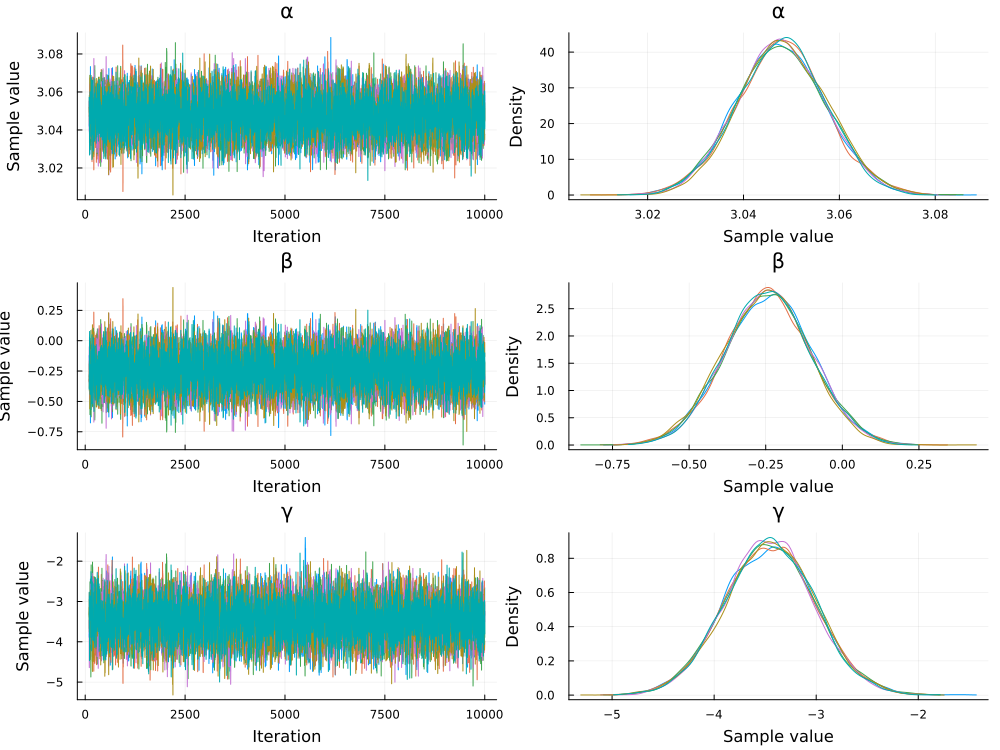

In [25]:
using StatsPlots
plot(ch[100:end,:,:])

In [ ]:
# using DelimitedFiles
# data = readdlm("data.txt")
# t, y, yerr = data[:, 1], data[:, 2], data[:, 3]


# Turing.Inference.getparams(::Turing.Model, sample::ESSample) = sample.x

# fun(x,α,β,γ) = @. α * x^2 + β * x + γ
# x = 0.0:0.5:15.0

# @model function InferenceModel(y)
# 	α ~ Normal(2, 1)
# 	β ~ Normal(0, 1)
# 	γ ~ Normal(-2, 1)

# 	y ~ MvNormal(fun(x, α, β, γ), 1)
# end

# m = InferenceModel(y)
# m2 = m | (α=1.0, β=0.3, γ=-2.)

In [ ]:
# DynamicPPL.SampleFromPrior()